In [48]:
#these are the libraries that are required to execute, quite obvious 
import pandas as pd
import numpy as np
import re
import spacy
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import mean_absolute_error



In [ ]:
#  loading the small English spaCy model for NER
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Load dataset
politifact_real = pd.read_csv('politifact_real.csv')
politifact_fake = pd.read_csv('politifact_fake.csv')
gossipcop_real = pd.read_csv('gossipcop_real.csv')
gossipcop_fake = pd.read_csv('gossipcop_fake.csv')

In [ ]:
# Labeling the datasets
politifact_real['label'] = 1
politifact_fake['label'] = 0
gossipcop_real['label'] = 1
gossipcop_fake['label'] = 0

In [ ]:
# Combining the datasets, Making a dataframe
df = pd.concat([politifact_real, politifact_fake, gossipcop_real, gossipcop_fake], ignore_index=True)

In [ ]:
#it frops the empty-entry from title column 
df = df.dropna(subset=['title'])



In [ ]:
# Simple text preprocessing
def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Removes the HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Normalize to lowercase
    return text

In [ ]:
#applying the function to the title column and saving it.
df['processed_title'] = df['title'].apply(preprocess_text)

In [ ]:
# Named Entity Recognition (NER) - Extract entities (ORG, GPE, PERSON)
def extract_entities(text):
    doc = nlp(text)
    entity_counts = {"ORG": 0, "GPE": 0, "PERSON": 0}  # Entity categories to track
    for ent in doc.ents:
        if ent.label_ in entity_counts:
            entity_counts[ent.label_] += 1
    return entity_counts

df['entity_counts'] = df['processed_title'].apply(extract_entities)

In [ ]:
# Normalize entity counts into separate columns
entity_df = pd.json_normalize(df['entity_counts'])
df = pd.concat([df, entity_df], axis=1)

In [ ]:
# Add additional features: article length and sentiment score
df['article_length'] = df['title'].apply(lambda x: len(x.split()))  # Number of words in article
df['sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)  # Sentiment polarity score

In [ ]:
# Define features for modeling
features = ['ORG', 'GPE', 'PERSON', 'article_length', 'sentiment']

In [ ]:
# Prepare the feature set and target variable
X = df[features]
y = df['label']  # Target: real (1) or fake (0)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Prepare the dataset for the Random Forest model
X = df[features]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
####Parameter hitting and seeting was done to improve the accuracy but was not able to receive higher accuracy 


# # Random Forest with GridSearchCV for hyperparameter tuning
# param_grid = {
#     'n_estimators': [108, 201, 342],
#     'max_depth': [9, 19, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rf = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best parameters and model
# best_rf = grid_search.best_estimator_
# print("Best Parameters:", grid_search.best_params_)

# # Predictions and metrics
# y_pred = best_rf.predict(X_test)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 342}



Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.10      0.16      1145
           1       0.76      0.94      0.84      3495

    accuracy                           0.73      4640
   macro avg       0.55      0.52      0.50      4640
weighted avg       0.66      0.73      0.67      4640

Weighted F1 Score: 0.67
Mean Absolute Error: 0.27


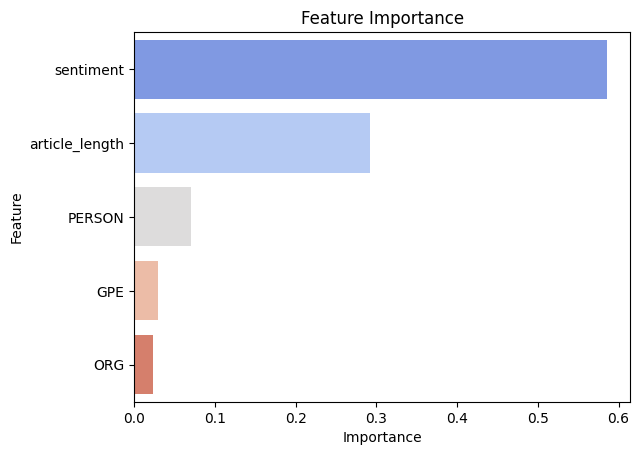

In [56]:
# # Classification Report
# print("\nClassification Report:\n", classification_report(y_test, y_pred))
# # F1 Score
# f1 = f1_score(y_test, y_pred, average='weighted')
# print(f"Weighted F1 Score: {f1:.2f}")

# # Mean Absolute Error
# mae = mean_absolute_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.2f}")

# # Feature Importance Plot
# importances = best_rf.feature_importances_
# feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')
# plt.title("Feature Importance")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.show()

In [57]:
# Train a Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [58]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7504310344827586
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.02      0.03      1145
           1       0.75      0.99      0.86      3495

    accuracy                           0.75      4640
   macro avg       0.57      0.50      0.45      4640
weighted avg       0.66      0.75      0.65      4640



In [ ]:
# Visualization

# 1. Bar chart for entity frequencies
entity_totals = df[['ORG', 'GPE', 'PERSON','article_length','sentiment','label']].sum()
entity_totals.plot(kind='bar', title='Entity Frequencies')
plt.ylabel('Frequency')
plt.show()

# 2. Scatter plot illustrating correlations
sns.scatterplot(x='sentiment', y='article_length', hue='label', data=df)
plt.title("Sentiment vs Article Length")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Article Length")
plt.show()

# 3. Heatmap for the relationship between features and engagement metrics
# Drop columns with zero variance
valid_features = [col for col in features + ['label'] if df[col].std() > 0]
correlation_matrix = df[valid_features].corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation with Article Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

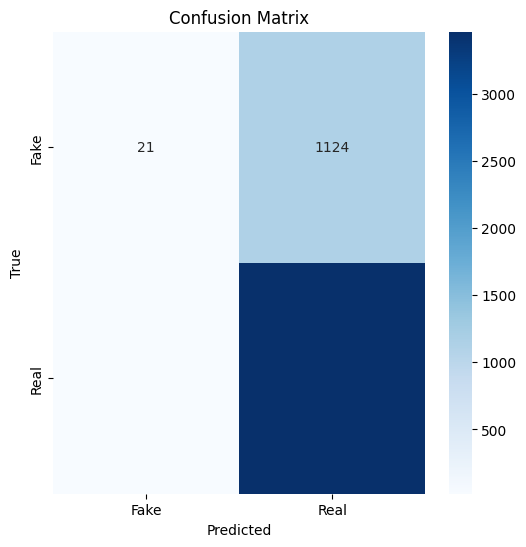

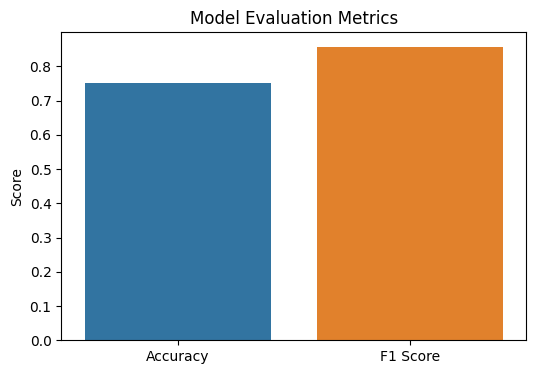

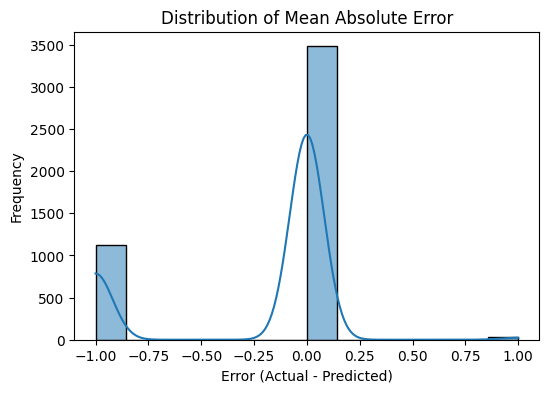

In [62]:

# Evaluate the model
y_pred = rf_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 Score and Accuracy Bar Plot
metrics = {'Accuracy': accuracy, 'F1 Score': f1}
plt.figure(figsize=(6, 4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.show()

# Mean Absolute Error Histogram
plt.figure(figsize=(6, 4))
sns.histplot(y_test - y_pred, kde=True)
plt.title('Distribution of Mean Absolute Error')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()
